In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Operations

### Constant (inmutables)

In [ ]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [ ]:
t.shape, t.dtype

(TensorShape([2, 3]), tf.float32)

In [ ]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [ ]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [ ]:
print(tf.square(t))
print(t @ tf.transpose(t))

tf.Tensor(
[[ 1.  4.  9.]
 [16. 25. 36.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)


### Variables (mutables)

In [ ]:
v = tf.Variable([1, 2, 3])

In [ ]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([2, 4, 6], dtype=int32)>

In [ ]:
v[1].assign(10)

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([ 2, 10,  6], dtype=int32)>

## Custom loss function

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

#### Functional

In [ ]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5

    return tf.where(is_small_error, squared_loss, linear_loss)

In [ ]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

model.compile(loss=huber_fn, optimizer='adam', metrics=['mae'])
model.fit(
    x = X_train_scaled,
    y = y_train, epochs=1000,
    validation_data = (X_valid_scaled, y_valid),
    callbacks = [
        early_stopping_cb
    ]
)

In [ ]:
model.save('my_model.h5')
loaded_model = keras.models.load_model('my_model.h5', custom_objects={ 'huber_fn': huber_fn })

#### Subclassing

In [ ]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.abs(error)
        is_small_error = abs_error <= self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * abs_error - self.threshold**2 / 2

        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'threshold': self.threshold
        }

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

model.compile(loss=HuberLoss(2.), optimizer='adam', metrics=['mae'])
model.fit(
    x = X_train_scaled,
    y = y_train, epochs=1000,
    validation_data = (X_valid_scaled, y_valid),
    callbacks = [
        early_stopping_cb
    ]
)

In [ ]:
model.save('my_model.h5')
loaded_model = keras.models.load_model('my_model.h5', custom_objects={ 'HuberLoss': HuberLoss })
loaded_model.loss.threshold

2.0

## Custom Components

### Activation Function

In [ ]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

### Initializer

In [ ]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2.0 / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

### Regularizer

In [ ]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, l1=0.01, **kwargs):
        self.l1 = l1
        super().__init__(**kwargs)

    def __call__(self, weights):
        return self.l1 * tf.reduce_sum(tf.abs(weights))

    def get_config(self):
        return {
            'l1': self.l1
        }


### Constraint

In [ ]:
def my_positive_weights(weights):
    return tf.where(weights < 0.0, tf.zeros_like(weights), weights)

**Training with custom**

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(
        units=30,
        input_shape=input_shape,
        activation='selu',
        kernel_initializer='lecun_normal',
    ),
    keras.layers.Dense(
        units=1,
        activation=my_softplus,
        kernel_regularizer=MyL1Regularizer(),
        kernel_constraint=my_positive_weights,
        kernel_initializer=my_glorot_initializer
    ),
])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)

model.compile(loss=HuberLoss(2.), optimizer='nadam', metrics=['mae'])
model.fit(
    x = X_train_scaled,
    y = y_train, epochs=1000,
    validation_data = (X_valid_scaled, y_valid),
    callbacks = [
        early_stopping_cb
    ]
)

In [ ]:
model.save('my_model.h5')
loaded_model = keras.models.load_model(
    filepath='my_model.h5',
    custom_objects={
        'my_softplus': my_softplus,
        'my_glorot_initializer': my_glorot_initializer,
        'MyL1Regularizer': MyL1Regularizer,
        'my_positive_weights': my_positive_weights,
        'HuberLoss': HuberLoss
    }
)

### Custom metrics

#### What's streaming metric?

In [ ]:
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]) # 0.8 in this batch

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [ ]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]) # 0.5 over ALL batches (2 until now)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.result() # Last precision

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [ ]:
precision.variables # Tracking necessary variables for result

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [ ]:
precision.reset_states()
print(precision.variables)
print(precision.result())

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>, <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]
tf.Tensor(0.0, shape=(), dtype=float32)


#### Custom streaming metric

In [ ]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.total = self.add_weight('total', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')
        
    def huber_fn(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.abs(error)
        is_small_error = abs_error <= self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * abs_error - self.threshold**2 / 2

        return tf.where(is_small_error, squared_loss, linear_loss)

    def update_state(self, y_true, y_pred):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'threshold': self.threshold
        }

In [ ]:
# Better implemented Huber metric
class HuberMetric2(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def huber_fn(self, y_true, y_pred):
        error = y_true - y_pred
        abs_error = tf.abs(error)
        is_small_error = abs_error <= self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * abs_error - self.threshold**2 / 2

        return tf.where(is_small_error, squared_loss, linear_loss)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

### Custom Layers

#### Lamda (without weights)

In [ ]:
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

# Equal than:
# - activation=tf.exp
# - activation=keras.activations.exponential
# - activation='exponential'

#### Layer

##### With weights

In [ ]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = activation


    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=[batch_input_shape[-1], self.units],
            initializer='glorot_normal'
        )
        self.bias = self.add_weight(
            name='bias',
            shape=[self.units],
            initializer='zeros'
        )
        super().build(batch_input_shape) # At the end

    def call(self, X):
        return self.activation(X @ self.kernel + bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'units': self.units,
            'activation': keras.activations.serialize(self.activation)
        }

##### Different behavior in training

In [ ]:
class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(t.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'stddev': self.stddev
        }

### Custom Models

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [
            keras.layers.Dense(
                units=n_neurons,
                activation='elu',
                kernel_initializer='he_normal'
            )
            for _ in range(n_layers)
        ]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)

        return inputs + Z

class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)

        self.hidden1 = keras.layers.Dense(
            units=30,
            activation='elu',
            kernel_initializer='he_normal'
        )

        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(3 + 1):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=5,
    callbacks=[early_stopping_cb]
)
print(model.evaluate(X_test_scaled, y_test))

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 9.1324 - val_loss: 7.6931
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0578 - val_loss: 9.1102
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8866 - val_loss: 6.7251
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5842 - val_loss: 43.5477
Epoch 5/5
162/162 [==============================] - 0s 967us/step - loss: 0.6481
0.6480705142021179


## Autodiff

### Gradients

In [ ]:
def f(w1, w2):
    return 3 * w1**2 + 2 * w1 * w2

w1 = tf.Variable(5.)
w2 = tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2]) # Just .gradient()
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [ ]:
w1 = tf.Variable(5.)
w2 = tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

gradients_w1 = tape.gradient(z, w1)
gradients_w2 = tape.gradient(z, w2)
del tape

gradients_w1, gradients_w2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    tape.watch(c1) # Now you can use .gradient with this constant
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2]) # Just .gradient()
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

### Custom Gradients

In [ ]:
w1 = tf.Variable(100.0)
with tf.GradientTape() as tape:
    Z = tf.math.log(1.0 + tf.exp(w1)) # softplus

tape.gradient(Z, w1) # Nan because is too big

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [ ]:
@tf.custom_gradient
def my_better_softplus(Z):
    exp = tf.exp(Z)

    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)

    return tf.math.log(exp + 1), my_softplus_gradients

w1 = tf.Variable(100.0)
with tf.GradientTape() as tape:
    Z = my_better_softplus(w1) # softplus

tape.gradient(Z, w1)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

## Custom Training Loops

In [ ]:
# Model
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(
        units=30,
        activation='elu',
        kernel_initializer='he_normal',
        kernel_regularizer=l2_reg
    ),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

# Utils
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)

    return X[idx], y[idx]

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = '>' if running else '='
    p = (size - 1) * iteration // total
    fmt = '{{:-{}d}}/{{}} [{{}}]'.format(len(str(total)))
    params = [iteration, total, '=' * p + c + '.' * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iter, total, loss, metrics=None):
    metrics = metrics or []
    metrics = ' - '.join([
        f'{m.name}: {round(float(m.result()), 4)}'
        for m in [loss] + metrics
    ])
    end = '' if iter < total else '\n'

    print(f'\r{progress_bar(iter, total)} - {metrics} - ' + metrics, end=end)
    

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [ ]:
for epoch in range(1, n_epochs + 1):
    print(f'Epoch {epoch}/{n_epochs}')
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(
            X_train_scaled.astype('float32'),
            y_train.astype('float32'), batch_size
        )

        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        for variable in model.trainable_variables:
            if variable.constraint is not None:
                variable.assign(variabel.constraint(variable))

        mean_loss(loss)

        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722 - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.528 - mean: 0.6774 - mean_absolute_error: 0.528
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177 - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181 - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.644 - mean_absolute_error: 0.5222 - mean: 0.644 - mean_absolute_error: 0.5222


## Graphs and Functions

In [29]:
@tf.function
def tf_cube(x):
    return x ** 3

print(tf_cube(2))
print(tf_cube.python_function(2))

tf.Tensor(8, shape=(), dtype=int32)
8


In [36]:
print(tf.autograph.to_code(tf_cube.python_function))

def tf__tf_cube(x):
    with ag__.FunctionScope('tf_cube', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = (ag__.ld(x) ** 3)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



## Exercises

### Custom Layer Normalization

In [74]:
class MyLayerNormalization(keras.layers.Layer):

    def __init__(self, epsilon=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name='alpha',
            shape=batch_input_shape[-1:],
            dtype=tf.float32,
            initializer='ones'
        )
        self.beta = self.add_weight(
            name='beta',
            shape=batch_input_shape[-1:],
            dtype=tf.float32,
            initializer='zeros'
        )
        super().build(batch_input_shape)

    def call(self, inputs):
        means, variances = tf.nn.moments(inputs, axes=-1, keepdims=True)
        # sqrt(0) derivative don't exist
        stddevs = tf.sqrt(variances + self.epsilon)

        normal = (inputs - means) / stddevs
        result = self.alpha * normal  + self.beta

        return result

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'epsilon': self.epsilon
        }

my_normal = MyLayerNormalization()
normal = keras.layers.LayerNormalization()

X = tf.constant([
    [1, 2, 3, 4],
    [10, 20, 50, 100]
], dtype=tf.float32)

assert tf.reduce_sum(my_normal(X) - normal(X)) < 1e-6

### Custom train loop

#### Normal loop

In [219]:
from tqdm.notebook import trange
from collections import OrderedDict, defaultdict

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

# Utils
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)

    return X[idx], y[idx]

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs = 10
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean(name='loss')
metrics = [keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
history = defaultdict(list)

with trange(1, n_epochs + 1, desc='All epochs') as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f'Epoch {epoch}/{n_epochs}') as steps:
            print(len(history['loss']))
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.autodiff.GradientTape() as tape:
                    y_pred = model(X_batch, training=True)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)
            
            y_pred = model(X_valid)
            val_loss = loss_fn(y_valid, y_pred)
            val_accuracy = keras.metrics.sparse_categorical_accuracy(
                y_valid,
                y_pred
            )
            val_loss = tf.reduce_mean(val_loss).numpy()
            val_accuracy = tf.reduce_mean(val_accuracy).numpy()
            status['val_loss'] = val_loss
            status['val_accuracy'] = val_accuracy
            steps.set_postfix(status)

            # History
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            for metric in metrics + [mean_loss]:
                # History
                history[metric.name].append(metric.result().numpy())

                # Reset
                metric.reset_states()

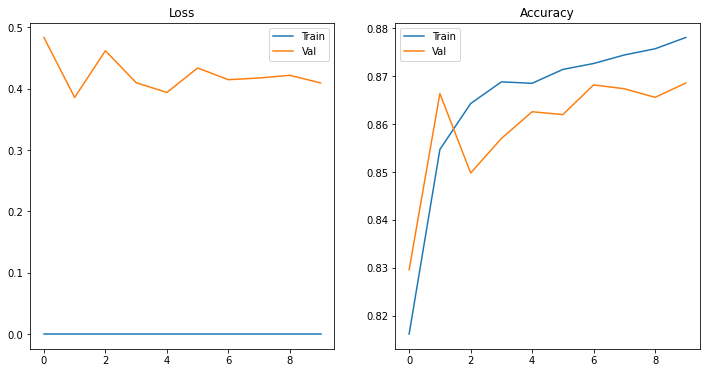

In [221]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt.sca(ax1)
plt.title('Loss')
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.legend()

plt.sca(ax2)
plt.title('Accuracy')
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.legend()

plt.show()

#### Two optimizers

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


lower_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
])
upper_layers = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax")                       
])
model = keras.models.Sequential([
    lower_layers, upper_layers
])

# Utils
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)

    return X[idx], y[idx]


# Train
n_epochs = 10
batch_size = 32
n_steps = len(X_train) // batch_size
lower_optimizer = keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
loss_fn = keras.losses.sparse_categorical_crossentropy
mean_loss = keras.metrics.Mean(name='loss')
metrics = [keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
history = defaultdict(list)

with trange(1, n_epochs + 1, desc='All epochs') as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f'Epoch {epoch}/{n_epochs}') as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.autodiff.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch, training=True)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                
                for layers, optimizer in ((lower_layers, lower_optimizer), (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                status['loss'] = mean_loss(loss).numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)
            
            y_pred = model(X_valid)
            val_loss = loss_fn(y_valid, y_pred)
            val_accuracy = keras.metrics.sparse_categorical_accuracy(
                y_valid,
                y_pred
            )
            val_loss = tf.reduce_mean(val_loss).numpy()
            val_accuracy = tf.reduce_mean(val_accuracy).numpy()
            status['val_loss'] = val_loss
            status['val_accuracy'] = val_accuracy
            steps.set_postfix(status)

            # History
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            for metric in metrics + [mean_loss]:
                # History
                history[metric.name].append(metric.result().numpy())

                # Reset
                metric.reset_states()

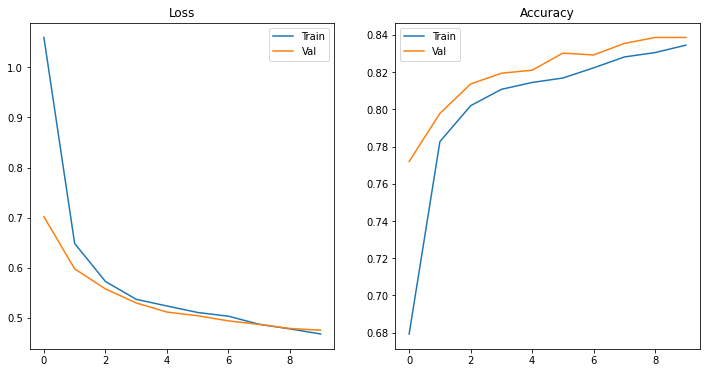

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt.sca(ax1)
plt.title('Loss')
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.legend()

plt.sca(ax2)
plt.title('Accuracy')
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.legend()

plt.show()